<a href="https://colab.research.google.com/github/higordevellard/hotel_sentiment_analysis/blob/main/NLP_Hotel_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning - NLP - Review de Hotels (EM DESENVOLVIMENTO)
# Sprint 02 - MVP parte 02






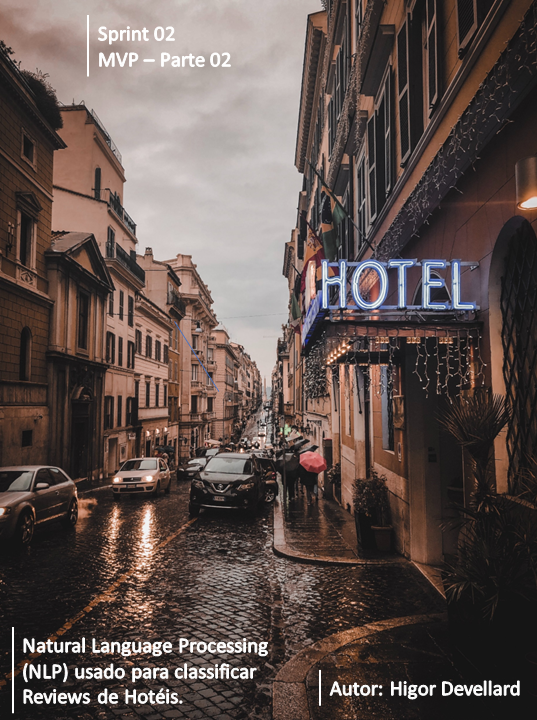

In [72]:
import requests
from PIL import Image
from io import BytesIO

# Carregar a capa do projeto usando a biblioteca PIL
imagem_1 = 'https://raw.githubusercontent.com/higordevellard/hotel_sentiment_analysis/main/images/imagem_1.png'
request_imagem = requests.get(imagem_1)
imagem = Image.open(BytesIO(request_imagem.content))
imagem.show()


## 1.Motivação

*   A satisfação do cliente desempenha um papel fundamental na indústria hoteleira, pois representa a base para o sucesso e a prosperidade de qualquer hotel. Quando os hóspedes estão satisfeitos, eles não apenas retornam ao estabelecimento, mas também o recomendam a amigos e familiares, resultando em um aumento no número de reservas e na reputação positiva do hotel. Além disso, a satisfação do cliente é um indicador crucial da qualidade dos serviços oferecidos, refletindo a capacidade do hotel em atender às expectativas e necessidades dos hóspedes. Ao priorizar a satisfação do cliente, os hotéis podem garantir uma experiência memorável e personalizada, desde o momento da reserva até o check-out.
*   Este projeto tem como objetivo utilizar técnicas de NLP para analisar um dataset contendo reviews elaborados por clientes e assim categorizar os comentários dando notas de zero à cinco.


## 2.Pacotes Usados

In [73]:
# Configuração para não exibir os warnings dos pacotes selecionados
import warnings
warnings.filterwarnings("ignore")

# Importação de pacotes
import requests
from PIL import Image
from io import BytesIO
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split




In [74]:
# Configuração para não exibir os warnings dos pacotes selecionados
import warnings
warnings.filterwarnings("ignore")

# instalando dependências
! pip install transformers[torch] datasets evaluate scikit-learn matplotlib

**Funções Auxiliares**

In [75]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from wordcloud import WordCloud
import seaborn as sns
import re
import string
from collections import Counter, defaultdict

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords_nltk = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [76]:
import re
from typing import Union, List

class CleanText():
    """ clearing text except digits () . , word character """

    def __init__(self, clean_pattern = r"[^A-ZĞÜŞİÖÇIa-zğüı'şöç0-9.\"',()]"):
        self.clean_pattern =clean_pattern

    def __call__(self, text: Union[str, list]) -> List[List[str]]:

        if isinstance(text, str):
            docs = [[text]]

        if isinstance(text, list):
            docs = text

        text = [[re.sub(self.clean_pattern, " ", sent) for sent in sents] for sents in docs]

        return text

def remove_emoji(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def tokenize(text):
    """ basic tokenize method with word character, non word character and digits """
    text = re.sub(r" +", " ", str(text))
    text = re.split(r"(\d+|[a-zA-ZğüşıöçĞÜŞİÖÇ]+|\W)", text)
    text = list(filter(lambda x: x != '' and x != ' ', text))
    sent_tokenized = ' '.join(text)
    return sent_tokenized

regex = re.compile('[%s]' % re.escape(string.punctuation))

def remove_punct(text):
    text = regex.sub(" ", text)
    return text

clean = CleanText()

## 3.Carga do Dataset

O dataset escolhido para este projeto está disponível no Kaggle, conforme o seguinte endereço: https://www.kaggle.com/code/sahillyraina/electric-faults-detection-classification/input


In [77]:
# Localicazão do dataset
url_1 = 'https://raw.githubusercontent.com/higordevellard/hotel_sentiment_analysis/main/review_hotel.csv'

# Labels dos atributos do dataset
labels_atributos = ['Review_Date', 'Average_Score', 'Hotel_Name', 'Reviewer_Nationality', \
                    'Negative_Review', 'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews', 'Positive_Review', \
                    'Review_Total_Positive_Word_Counts', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags', \
                    'days_since_review']
# Lê o arquivo
dataset = pd.read_csv(url_1, names=labels_atributos, header=0, delimiter=',')


### **3.1Informações sobre o dataset**

*   O dataset pode ser encontrado no Kaggle, no endereço abaixo, onde foi coletados reviews referente à diversos hoteis em regiões dos Estados Unidos:

https://www.kaggle.com/code/jonathanoheix/sentiment-analysis-with-hotel-reviews/notebook

O dataset carregado contém 13 atributos, sendo eles:

**Review_Date:** data em que foi feito o review.

**Average_Score:**nota média do hotel.

**Hotel_Name:**nome do hotel.

**Reviewer_Nationality:**nacionalidade do usuário que elaborou o review.

**Negative_Review:**pontos negativos sobre o hotel.

**Review_Total_Negative_Word_Counts:**quantidade total de palavras negativas.

**Total_Number_of_Reviews:**quantidade total de reviews do hotel.

**Positive_Review:**Pontos positivos da review.

**Review_Total_Positive_Word_Counts:**quantidade total de palavras positivas.

**Total_Number_of_Reviews_Reviewer_Has_Given:**quantidade de reviews que o usuário fez.

**Reviewer_Score:**nota do review.

**Tags:**tags usadas.

**days_since_review:**quantidade de dias que a review foi feita.



## 4.Análise Exploratória de Dados

###4.1 Análise e Tratamento dos dados

In [78]:
# Mostra as dimensões do dataset (linhas e colunas)
dataset.shape

(65000, 13)

In [79]:
# Mostra as informações do dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65000 entries, 0 to 64999
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Review_Date                                 65000 non-null  object 
 1   Average_Score                               65000 non-null  float64
 2   Hotel_Name                                  65000 non-null  object 
 3   Reviewer_Nationality                        65000 non-null  object 
 4   Negative_Review                             65000 non-null  object 
 5   Review_Total_Negative_Word_Counts           65000 non-null  int64  
 6   Total_Number_of_Reviews                     65000 non-null  int64  
 7   Positive_Review                             65000 non-null  object 
 8   Review_Total_Positive_Word_Counts           65000 non-null  int64  
 9   Total_Number_of_Reviews_Reviewer_Has_Given  65000 non-null  int64  
 10  Reviewer_S

**Observações importantes levantadas após os resultados da função .info():**

1)Todos os 13 atributos foram devidamente carregados.

2)Todas as 65.000 Instâncias (linhas) são não nulas (Sem missings).



In [80]:
# Mostra as 5 primeiras linhas do dataset
dataset.head(5)

,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review
0,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days
1,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days
2,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days
3,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days
4,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days


Como no dataset as avaliações positivas estão armazenadas em um atributo e as negativas em outro, será necessário realizar a concatenação dos dois atributos.

In [81]:
dataset["review"] = dataset["Negative_Review"] + dataset["Positive_Review"]

In [82]:
dataset.head()

,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,review
0,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,I am so angry that i made this post available...
1,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,No Negative No real complaints the hotel was g...
2,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,Rooms are nice but for elderly a bit difficul...
3,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,My room was dirty and I was afraid to walk ba...
4,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,You When I booked with your company on line y...


Considerando que no atributo "Reviewer_Score" é dada uma nota ao hotel, será dado uma classificação para cada faixa de nota.

In [83]:
def assign_value(x):
    if x < 4:
        return 0
    elif x >= 4 and x < 6:
        return 1
    elif x >= 6:
        return 2

dataset["review_classification"] = dataset["Reviewer_Score"].apply(assign_value)

In [84]:
# label to name
def label2name(x):
    if x == 0:
        return "Negativo"
    if x == 1:
        return "Neutro"
    if x == 2:
        return "Positivo"

In [85]:
dataset_2 = dataset[["review", "Average_Score", "review_classification"]]
dataset_2["label_name"] = dataset_2["review_classification"].apply(lambda x: label2name(x))

In [86]:
# remove 'No Negative' or 'No Positive' from text
dataset_2["review"] = dataset_2["review"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))

In [87]:
# clean text, lowercase and remove punk
dataset_2["review"] = dataset_2["review"].apply(lambda x: remove_punct(clean(remove_emoji(x).lower())[0][0]))

No dataset escolhido quando o usuário opta por não preencher o atributo "Negative_Review" ou "Positive_Review", automaticamente o dataset é preenchido com "No Negative" ou "No positive", o que não irá ajudar no treinamento do modelo, podendo até atrapalhar no desempenho do mesmo.

In [88]:
dataset_2.head()

,review,Average_Score,review_classification,label_name
0,i am so angry that i made this post available...,7.7,0,Negativo
1,no real complaints the hotel was great great ...,7.7,2,Positivo
2,rooms are nice but for elderly a bit difficul...,7.7,2,Positivo
3,my room was dirty and i was afraid to walk ba...,7.7,0,Negativo
4,you when i booked with your company on line y...,7.7,2,Positivo


### **4.2.Estatísticas Descritivas**

**Balanceamento dos Dados**

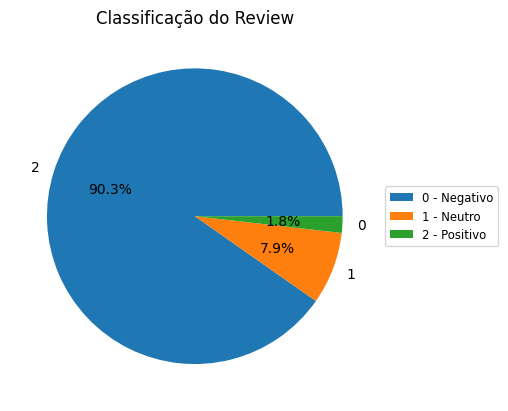

In [89]:
# Obtendo a contagem dos valores únicos do atributo "Tipo_de_Curto_Circuito"
contagem_valores = dataset_2['review_classification'].value_counts()

# Obtendo os valores únicos e suas respectivas contagens
valores_unicos = contagem_valores.index
contagens = contagem_valores.values

# Definindo as descrições correspondentes a cada valor único
descricoes = ['0 - Negativo',
              '1 - Neutro',
              '2 - Positivo']

# Plotando o gráfico de pizza com porcentagem
plt.pie(contagens, labels=valores_unicos, autopct='%1.1f%%')

# Adicionando a legenda personalizada ao lado do gráfico
plt.legend(descricoes, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

# Definindo o título do gráfico
plt.title('Classificação do Review')

# Exibindo o gráfico
plt.show()

Pelo gráfico acima, pode-se perceber que há um desbalanceamento, onde mais de 65% dos registros estão na faixa (0 - Péssimo).

# **5.Visualizações**

Word Cloud

In [90]:
from wordcloud import WordCloud

In [91]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        max_words=200,
        max_font_size=40,
        scale=1,
        random_state=1
).generate(" ".join(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

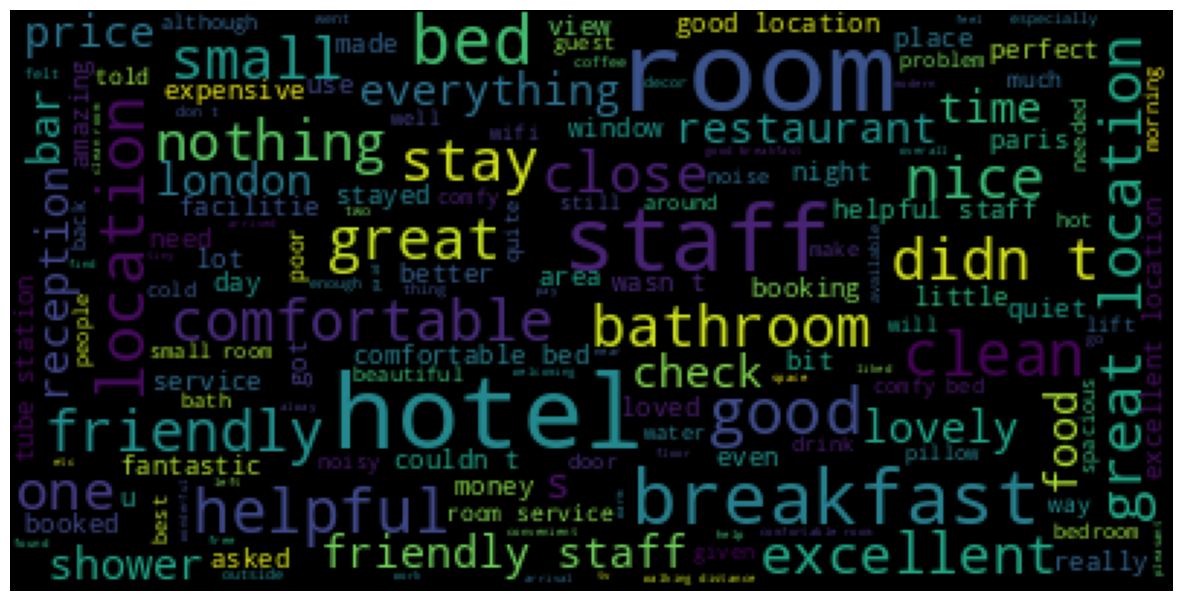

In [92]:
show_wordcloud(dataset_2["review"].values)

Target Count

In [93]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "bar"}]])
colors = ['gold', 'mediumturquoise', 'lightgreen'] # darkorange
fig.add_trace(go.Pie(labels=dataset_2.label_name.value_counts().index,
                             values=dataset_2.review_classification.value_counts().values), 1, 1)

fig.update_traces(hoverinfo='label+percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.add_trace(go.Bar(x=dataset_2.label_name.value_counts().index, y=dataset_2.review_classification.value_counts().values, marker_color = colors), 1,2)

fig.show()

Token Counts with simple tokenizer

In [94]:
# tokenize data
dataset_2["tokenized_review"] = dataset_2.review.apply(lambda x: tokenize(x))
# calculate token count for any sent
dataset_2["token_comprimento"] = dataset_2["tokenized_review"].apply(lambda x: len(x.split()))

In [95]:
fig = px.histogram(dataset_2, x="token_comprimento", nbins=20, color_discrete_sequence=px.colors.cmocean.algae, barmode='group', histnorm="percent")
fig.show()

In [96]:
(dataset_2.token_comprimento < 128).mean()

0.9718461538461538

Token com o BERT

In [97]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

In [98]:
# data tokenize with bert tokenizer
dataset_2["BERT_token_comprimento"] = dataset_2["review"].apply(lambda x: len(tokenizer(x, add_special_tokens=False)["input_ids"]))

Token indices sequence length is longer than the specified maximum sequence length for this model (578 > 512). Running this sequence through the model will result in indexing errors


In [99]:
fig = px.histogram(dataset_2, x="token_comprimento", nbins=20, color_discrete_sequence=px.colors.cmocean.algae, barmode='group', histnorm="percent")
fig.show()

In [100]:
# Less than 512 covers how many of the data
(dataset_2.BERT_token_comprimento < 512).mean()

0.9999230769230769

Characters Count in the Data

In [101]:
# valvulate char count for each review
dataset_2['char_count'] = dataset_2['review'].apply(lambda x: len(str(x)))


def plot_dist3(dataset_2, feature, title):
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.distplot(dataset_2.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 )
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))


    plt.suptitle(f'{title}', fontsize=24)

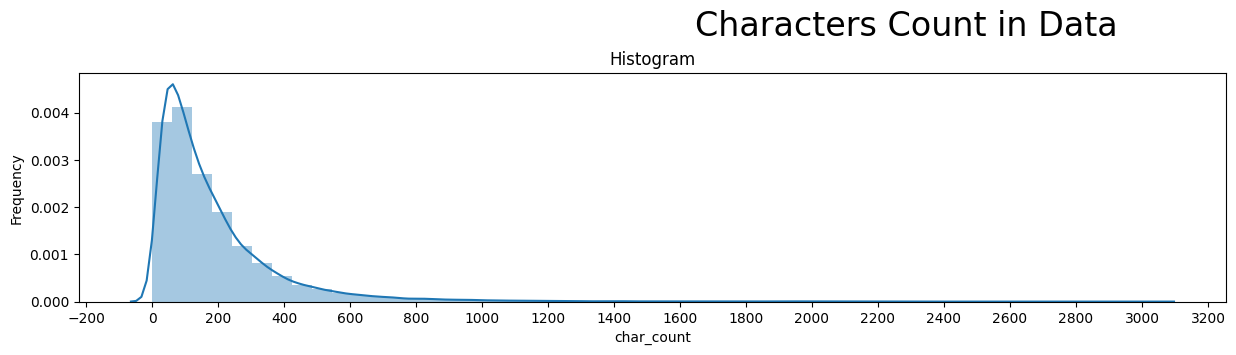

In [102]:
plot_dist3(dataset_2, 'char_count',
           'Characters Count in Data')

Review Lengths

In [103]:
# Creating a new feature for the visualization.
dataset_2['Character Count'] = dataset_2['review'].apply(lambda x: len(str(x)))


def plot_dist3(dataset_2, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(24, 12))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(dataset_2.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(dataset_2.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    plt.suptitle(f'{title}', fontsize=24)

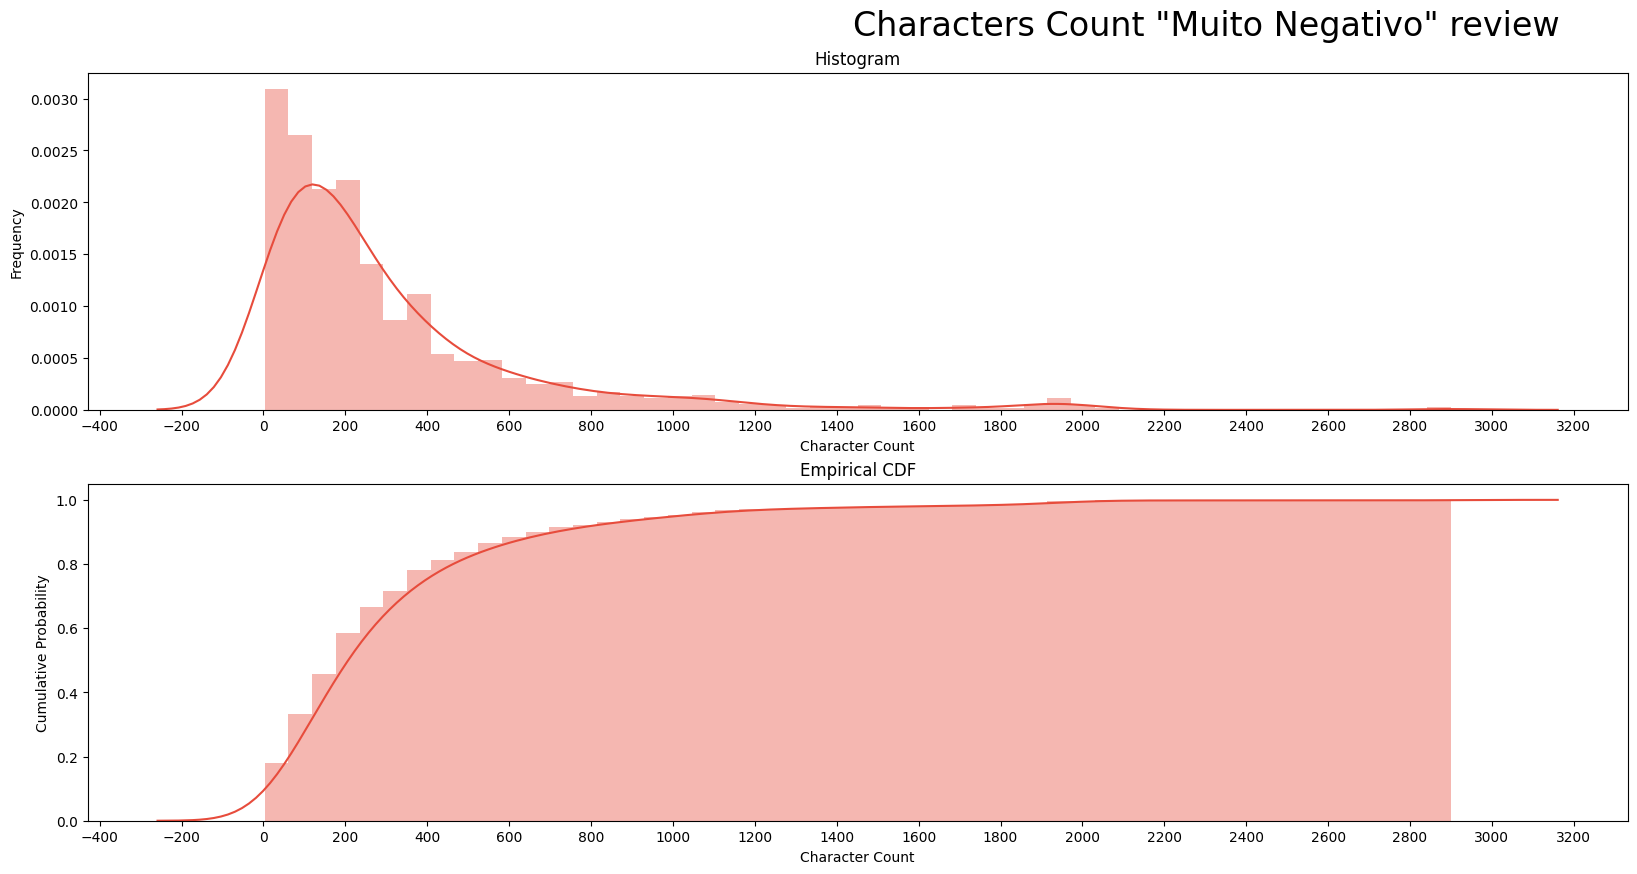

In [104]:
plot_dist3(dataset_2[dataset_2['review_classification'] == 0], 'Character Count',
           'Characters Count "Muito Negativo" review')

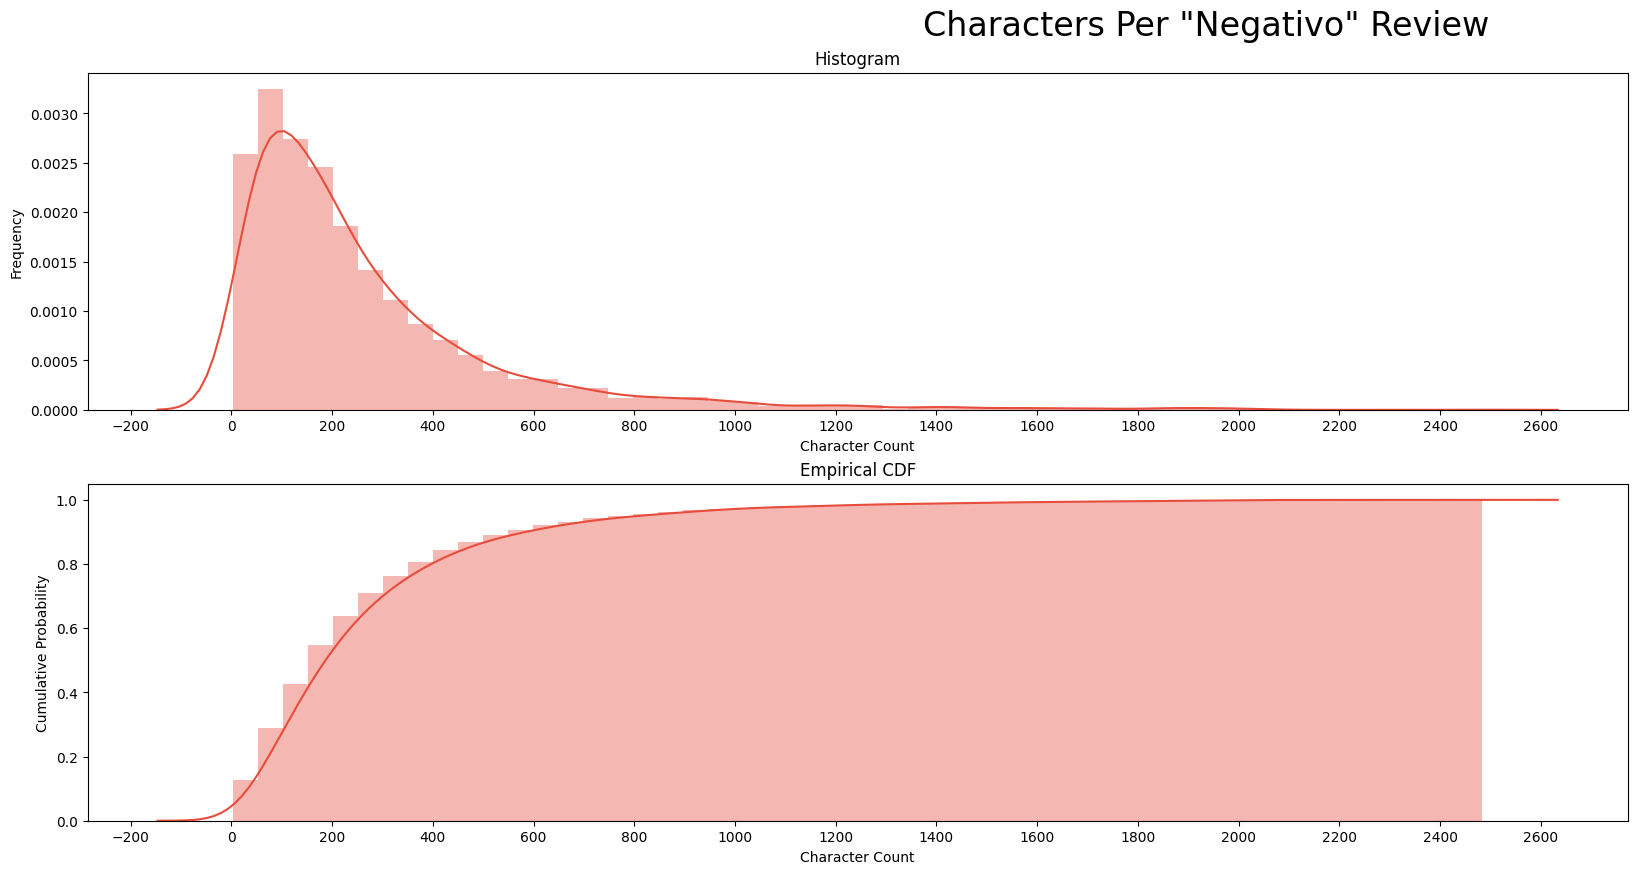

In [105]:
plot_dist3(dataset_2[dataset_2['review_classification'] == 1], 'Character Count',
           'Characters Per "Negativo" Review')

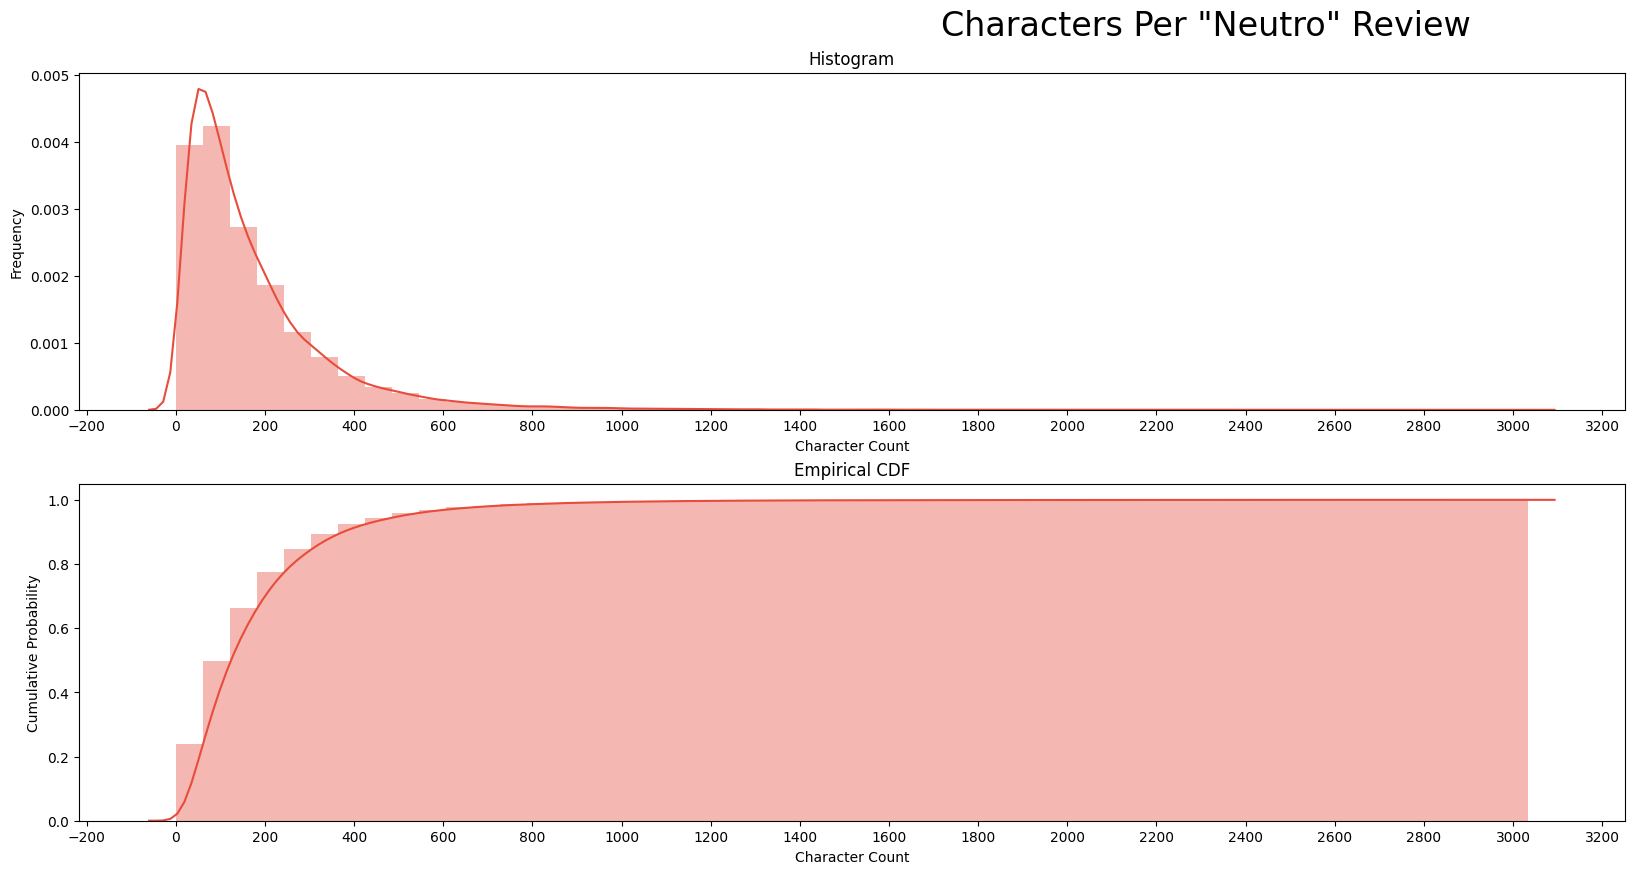

In [106]:
plot_dist3(dataset_2[dataset_2['review_classification'] == 2], 'Character Count',
           'Characters Per "Neutro" Review')

Words Counts

In [114]:
def plot_word_number_histogram(texta, textyb, textc):

    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(18, 12), sharey=True)
    sns.distplot(texta.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
    sns.distplot(textyb.str.split().map(lambda x: len(x)), ax=axes[1], color='#e74c3c')
    sns.distplot(textc.str.split().map(lambda x: len(x)), ax=axes[2], color='#e74c3c')


    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Negativo')
    axes[1].set_xlabel('Word Count')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Neutro')
    axes[2].set_xlabel('Word Count')
    axes[2].set_ylabel('Frequency')
    axes[2].set_title('Positivo')

    fig.suptitle('Words Per Review', fontsize=24, va='baseline')

    fig.tight_layout()

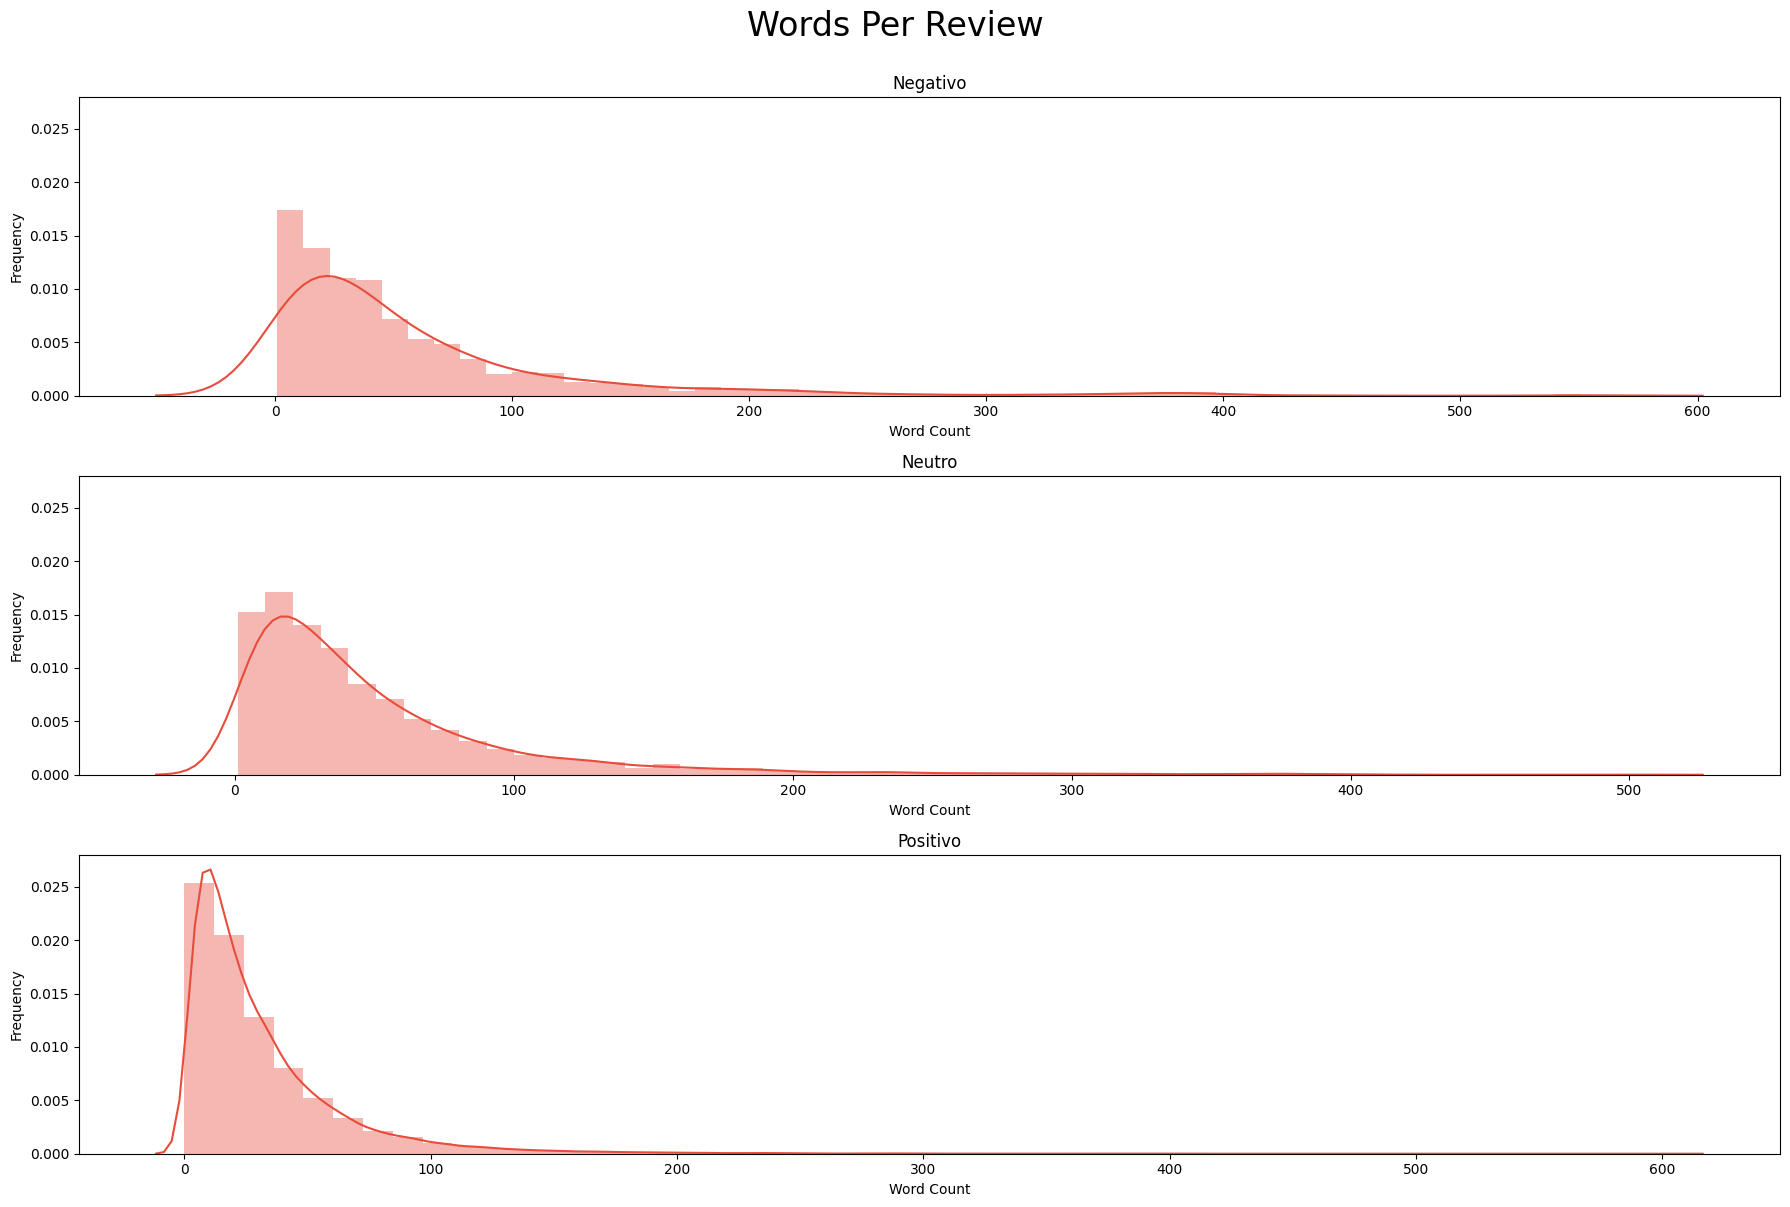

In [115]:
plot_word_number_histogram(dataset_2[dataset_2['review_classification'] == 0]['review'],
                           dataset_2[dataset_2['review_classification'] == 1]['review'],
                           dataset_2[dataset_2['review_classification'] == 2]['review'],
                          )

In [116]:
# remove punk
dataset_2['tokenized_review'] = dataset_2['tokenized_review'].apply(lambda x: remove_punct(x))

Palavras mais comuns

In [117]:
texts = dataset_2['tokenized_review']
new = texts.str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]
counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word, count in most[:30]:
    if word not in stopWords_nltk:
        x.append(word)
        y.append(count)

fig = go.Figure(go.Bar(
            x=y,
            y=x,
            orientation='h',  marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),
    name='Most common Word',))

fig.update_layout( title={
        'text': "Most Common Words",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ))

fig.show()

Most Common ngrams

In [118]:
fig = make_subplots(rows=1, cols=3)
title_ = ["Negativo", "Neutro", "Positivo"]
colors = ["red", "orange", "yellow"]  # Exemplo de lista fictícia de cores

for i in range(5):
    texts = dataset_2[dataset_2["review_classification"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []

    for word, count in most[:30]:
        if word not in stopWords_nltk:
            x.append(word)
            y.append(count)

    fig.add_trace(go.Bar(
        x=y,
        y=x,
        orientation='h',
        type="bar",
        name=title_[i],
        marker=dict(color=colors[i])
    ), row=1, col=i+1)

fig.update_layout(
    autosize=False,
    width=2000,
    height=600,
    title=dict(
        text='<b>Most Common ngrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
            family="Courier New, monospace",
            size=24,
            color="RebeccaPurple"
        )
    ),
)

fig.show()

IndexError: ignored

In [ ]:
def _get_top_ngram(corpus, n=None):
    #getting top ngrams
    vec = CountVectorizer(ngram_range=(n, n),
                          max_df=0.9,
                          ).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:15]

In [ ]:
# unigram
fig = make_subplots(rows=1, cols=3)

title_ = ["Negativo", "Neutro", "Positivo"]
colors = ["red", "orange", "yellow"]  # Exemplo de lista fictícia de cores

for i in range(5):
    texts = dataset_2[dataset_2["review_classification"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    top_n_bigrams = _get_top_ngram(texts, 2)[:15]
    x, y = map(list, zip(*top_n_bigrams))


    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1)


fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common unigrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ))
fig.show()

In [ ]:
#trigram

fig = make_subplots(rows=1, cols=3)

title_ = ["Negativo", "Neutro", "Positivo"]
colors = ["red", "orange", "yellow"]  # Exemplo de lista fictícia de cores

for i in range(5):
    texts = dataset_2[dataset_2["review_classification"] == i]['tokenized_review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    top_n_bigrams = _get_top_ngram(texts, 3)[:15]
    x, y = map(list, zip(*top_n_bigrams))

    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1),

fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common trigrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ))

fig.show()

BERT

In [ ]:
import pandas as pd
import numpy as np
import os
import random
from pathlib import Path
import json

In [ ]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [ ]:
class Config():
    seed_val = 17
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    epochs = 5
    batch_size = 4
    seq_length = 512
    lr = 2e-5
    eps = 1e-8
    pretrained_model = 'bert-base-uncased'
    test_size=0.15
    random_state=42
    add_special_tokens=True
    return_attention_mask=True
    pad_to_max_length=True
    do_lower_case=False
    return_tensors='pt'

config = Config()

In [ ]:
# params will be saved after training
params = {"seed_val": config.seed_val,
    "device":str(config.device),
    "epochs":config.epochs,
    "batch_size":config.batch_size,
    "seq_length":config.seq_length,
    "lr":config.lr,
    "eps":config.eps,
    "pretrained_model": config.pretrained_model,
    "test_size":config.test_size,
    "random_state":config.random_state,
    "add_special_tokens":config.add_special_tokens,
    "return_attention_mask":config.return_attention_mask,
    "pad_to_max_length":config.pad_to_max_length,
    "do_lower_case":config.do_lower_case,
    "return_tensors":config.return_tensors,
         }

In [ ]:
# set random seed and device
import random

device = config.device

random.seed(config.seed_val)
np.random.seed(config.seed_val)
torch.manual_seed(config.seed_val)
torch.cuda.manual_seed_all(config.seed_val)

In [ ]:
dataset_2.head()

Treino e validação

In [ ]:
#split train test
from sklearn.model_selection import train_test_split

train_df_, val_df = train_test_split(dataset_2,
                                    test_size=0.30,
                                    random_state=config.random_state,
                            stratify=dataset_2.review_classification.values)

Treino e Teste

In [ ]:
train_df, test_df = train_test_split(train_df_,
                                    test_size=0.30,
                                    random_state=42,
                            stratify=train_df_.review_classification.values)

In [ ]:
# count of unique label  control
print(len(train_df['review_classification'].unique()))
print(train_df.shape)

In [ ]:
# count of unique label  control
print(len(val_df['review_classification'].unique()))
print(val_df.shape)

In [ ]:
print(len(test_df['review_classification'].unique()))
print(test_df.shape)

BertTokenizer and Encoding the Data

In [ ]:
# create tokenizer
tokenizer = BertTokenizer.from_pretrained(config.pretrained_model,
                                          do_lower_case=config.do_lower_case)

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    train_df.review.values,
    add_special_tokens=config.add_special_tokens,
    return_attention_mask=config.return_attention_mask,
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length,
    return_tensors=config.return_tensors
)
encoded_data_val = tokenizer.batch_encode_plus(
    val_df.review.values,
    add_special_tokens=config.add_special_tokens,
    return_attention_mask=config.return_attention_mask,
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length,
    return_tensors=config.return_tensors
)

In [ ]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_df.review_classification.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val_df.review_classification.values)

In [ ]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Creating the Model

In [ ]:
model = BertForSequenceClassification.from_pretrained(config.pretrained_model,
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

carregamento

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=config.batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=config.batch_size)

Optimizer & Scheduler

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=config.lr,
                  eps=config.eps)


scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*config.epochs)

Performance Metrics

In [ ]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels, label_dict):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

Treinamento do loop

In [ ]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(config.device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    # calculate avareage val loss
    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [ ]:
config.device

In [ ]:
model.to(config.device)

for epoch in tqdm(range(1, config.epochs+1)):

    model.train()

    loss_train_total = 0
    # allows you to see the progress of the training
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)

    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(config.device) for b in batch)


        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    torch.save(model.state_dict(), f'_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')

    tqdm.write(f'F1 Score (Weighted): {val_f1}');
# save model params and other configs
with Path('params.json').open("w") as f:
    json.dump(params, f, ensure_ascii=False, indent=4)

## **6.Conclusão**